## Step 1: 환경 설정

In [1]:
import sys
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import torch
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import math
import pickle

# 현재 디렉토리를 경로에 추가 (모듈 로드용)
current_dir = Path('.').resolve()
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
# 모듈 임포트
from preparation import get_device, load_models
from sequence_generation import fetch_gene_sequences, sort_genes_by_length
from visualization import (
    cosine_series_from_embeddings,
    calculate_shannon_entropy
)

print("✅ 환경 설정 완료")

# matplotlib 설정
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11


✅ 환경 설정 완료


## Step 2: 디바이스 및 모델 로드

In [2]:
# 디바이스 설정
device = get_device()
print(f"\n사용 중인 디바이스: {device}")

# 모델 로드 (generator/evaluator에 사용할 두 모델만)
model_configs = {
    'DNABERT-2': 'zhihan1996/DNABERT-2-117M',
    "NT-v2-50m": "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species",
    'NT-v2-500m': 'InstaDeepAI/nucleotide-transformer-v2-500m-multi-species',
}
models = load_models(device, model_configs)
print(f"로드된 모델: {list(models.keys())}")


PyTorch Version: 2.9.1
Using device: mps

사용 중인 디바이스: mps
📥 Downloading DNABERT-2...


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

✅ DNABERT-2 Triton patch applied successfully.
[DNABERT-2] Loading model...


/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


[DNABERT-2] Model loaded successfully.
✅ DNABERT-2 loaded successfully.
[NT-v2-50m] Loading model...
[NT-v2-50m] Model loaded successfully.
✅ NT-v2-50m loaded successfully.
[NT-v2-500m] Loading model...
[NT-v2-500m] Model loaded successfully.
✅ NT-v2-500m loaded successfully.

🚀 3 model(s) ready!
로드된 모델: ['DNABERT-2', 'NT-v2-50m', 'NT-v2-500m']


## Step 3: 생성된 시퀀스 로드

# load model/generated_seq/embeddings


In [3]:
# 결과 디렉토리 설정
SEQ_DIR = Path('results/sequences')

# 모든 시퀀스 로드
all_sequences = {}  # {model_name: {gene_id: {strategy: [sequences]}}}

for model_key in models.keys():
    model_name = model_key.replace("/", "-")
    model_dir = SEQ_DIR / model_name
    all_sequences[model_name] = {}
    
    print(f"\n로드 중: {model_key}")
    
    for csv_file in model_dir.glob("*.csv"):
        gene_id = csv_file.stem
        df = pd.read_csv(csv_file, index_col=0)
            
        # DataFrame을 dictionary로 변환
        sequences_dict = {}
        for strategy in df.index:
            sequences_dict[strategy] = df.loc[strategy].tolist()
        
        all_sequences[model_name][gene_id] = sequences_dict
        print(f"  ✓ {gene_id}: {len(sequences_dict)} strategies")

print(f"\n✅ 시퀀스 로드 완료")
print(f"모델: {list(all_sequences.keys())}")
print(f"유전자: {list(all_sequences[list(all_sequences.keys())[0]].keys())}")


로드 중: DNABERT-2
  ✓ HOXC11: 4 strategies
  ✓ TP53: 4 strategies
  ✓ NORAD: 4 strategies
  ✓ GAPDHP1: 4 strategies
  ✓ VEGFA: 4 strategies
  ✓ HBB: 4 strategies
  ✓ TTN: 4 strategies
  ✓ H4C1: 4 strategies
  ✓ STAT3: 4 strategies
  ✓ TPI1: 4 strategies
  ✓ TPI1P1: 4 strategies
  ✓ GAPDH: 4 strategies
  ✓ PTENP1: 4 strategies
  ✓ NEAT1: 4 strategies
  ✓ PTEN: 4 strategies
  ✓ HOTAIR: 4 strategies

로드 중: NT-v2-50m
  ✓ HOXC11: 4 strategies
  ✓ TP53: 4 strategies
  ✓ NORAD: 4 strategies
  ✓ GAPDHP1: 4 strategies
  ✓ VEGFA: 4 strategies
  ✓ HBB: 4 strategies
  ✓ TTN: 4 strategies
  ✓ H4C1: 4 strategies
  ✓ STAT3: 4 strategies
  ✓ TPI1: 4 strategies
  ✓ TPI1P1: 4 strategies
  ✓ GAPDH: 4 strategies
  ✓ PTENP1: 4 strategies
  ✓ NEAT1: 4 strategies
  ✓ PTEN: 4 strategies
  ✓ HOTAIR: 4 strategies

로드 중: NT-v2-500m
  ✓ HOXC11: 4 strategies
  ✓ TP53: 4 strategies
  ✓ NORAD: 4 strategies
  ✓ GAPDHP1: 4 strategies
  ✓ VEGFA: 4 strategies
  ✓ HBB: 4 strategies
  ✓ TTN: 4 strategies
  ✓ H4C1: 4 strate

## Step 4: 임베딩 생성 및 로드 (Self/Cross)


In [5]:
# 임베딩 생성/로드 (self-eval + cross-eval)
def build_cross_embeddings(source_sequences, target_model_instance):
    """한 모델이 다른 모델의 시퀀스를 임베딩"""
    cross_emb = {}  # {gene_id: {strategy: [embeddings]}}
    for gene_id, strategies in source_sequences.items():
        cross_emb[gene_id] = {}
        for strategy, sequences in strategies.items():
            if not sequences:
                continue
            embeddings = []
            for seq in sequences:
                if pd.isna(seq) or seq == '':
                    continue
                try:
                    emb = target_model_instance.get_embedding(str(seq))
                    embeddings.append(emb)
                except Exception:
                    pass
            if embeddings:
                cross_emb[gene_id][strategy] = embeddings
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
            elif device == 'mps':
                torch.mps.empty_cache()
    return cross_emb

print('임베딩 생성/로드 중...')
generator_labels = list(models.keys())
evaluator_labels = list(models.keys())
print(f"generator_labels: {generator_labels}")
print(f"evaluator_labels: {evaluator_labels}")

# generator_labels = [m for m in ['DNABERT-2', 'NT-v2-500m'] if m in models]
# evaluator_labels = [m for m in ['DNABERT-2', 'NT-v2-500m'] if m in models]

RESULTS_DIR = Path('results')

EMBEDDINGS_CACHE_DIR = RESULTS_DIR / 'embeddings'
EMBEDDINGS_CACHE_DIR.mkdir(parents=True, exist_ok=True)

cross_embeddings = {}  # {(generator, evaluator): {gene_id: {strategy: [embeddings]}}}

for gen_label in generator_labels:
    for eval_label in evaluator_labels:
        cache_name = f'embeddings_{gen_label}__by__{eval_label}.pkl'
        cache_path = EMBEDDINGS_CACHE_DIR / cache_name

        loaded = False
        if cache_path.exists():
            try:
                with open(cache_path, 'rb') as f:
                    cross_embeddings[(gen_label, eval_label)] = pickle.load(f)
                print(f"  ✓ 캐시 로드: {cache_path}")
                loaded = True
            except Exception as e:
                print(f"  ⚠️ 캐시 로드 실패: {cache_path} ({e})")

        if loaded:
            continue

        print(f"\n임베딩 생성: {gen_label} sequences → {eval_label} evaluator")
        cross_emb = build_cross_embeddings(
            all_sequences[gen_label],
            models[eval_label]
        )
        cross_embeddings[(gen_label, eval_label)] = cross_emb
        with open(cache_path, 'wb') as f:
            pickle.dump(cross_emb, f, protocol=4)
        print(f"  ✓ 캐시 저장: {cache_path}")

# self-evaluation 임베딩 재사용
all_embeddings = {}  # {model_name: {gene_id: {strategy: [embeddings]}}}
for model_label in models.keys():
    key = (model_label, model_label)
    if key not in cross_embeddings:
        raise FileNotFoundError(f'self-eval 임베딩이 없습니다: {model_label} → {model_label}')
    all_embeddings[model_label] = cross_embeddings[key]

print('✅ 임베딩 준비 완료')


임베딩 생성/로드 중...
generator_labels: ['DNABERT-2', 'NT-v2-50m', 'NT-v2-500m']
evaluator_labels: ['DNABERT-2', 'NT-v2-50m', 'NT-v2-500m']
  ✓ 캐시 로드: results/embeddings/embeddings_DNABERT-2__by__DNABERT-2.pkl

임베딩 생성: DNABERT-2 sequences → NT-v2-50m evaluator
  ✓ 캐시 저장: results/embeddings/embeddings_DNABERT-2__by__NT-v2-50m.pkl

임베딩 생성: DNABERT-2 sequences → NT-v2-500m evaluator
  ✓ 캐시 저장: results/embeddings/embeddings_DNABERT-2__by__NT-v2-500m.pkl

임베딩 생성: NT-v2-50m sequences → DNABERT-2 evaluator
  ✓ 캐시 저장: results/embeddings/embeddings_NT-v2-50m__by__DNABERT-2.pkl

임베딩 생성: NT-v2-50m sequences → NT-v2-50m evaluator
  ✓ 캐시 저장: results/embeddings/embeddings_NT-v2-50m__by__NT-v2-50m.pkl

임베딩 생성: NT-v2-50m sequences → NT-v2-500m evaluator
  ✓ 캐시 저장: results/embeddings/embeddings_NT-v2-50m__by__NT-v2-500m.pkl

임베딩 생성: NT-v2-500m sequences → DNABERT-2 evaluator
  ✓ 캐시 저장: results/embeddings/embeddings_NT-v2-500m__by__DNABERT-2.pkl

임베딩 생성: NT-v2-500m sequences → NT-v2-50m evaluator
  ✓ 캐시 저장: re

In [6]:
all_embeddings.keys()

dict_keys(['DNABERT-2', 'NT-v2-50m', 'NT-v2-500m'])

---
# visualization


## 1. decoding strategy에 따른 model collapse


### overview
각 model별로 strategy에 대한 각 gene의 semantic similarity를 보여줍니다.


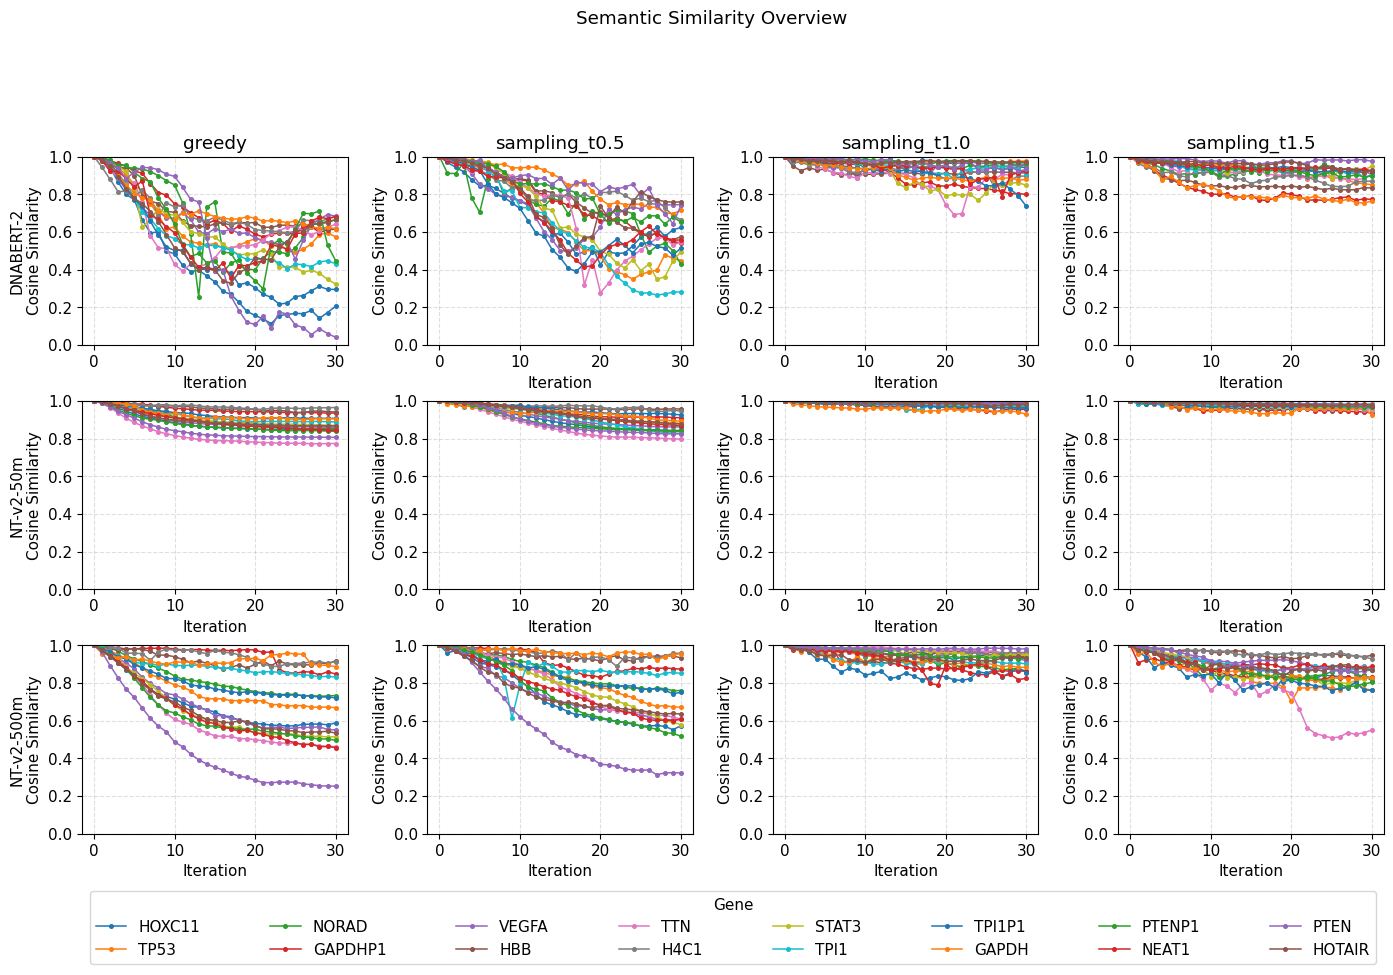

In [7]:
from visualization import (
    plot_strategy_collapse_with_ci,
    # plot_strategy_collapse_with_ci_side_by_side,
    plot_kmer_distribution_pair,
    plot_cross_validation_heatmap,
    cosine_series_from_embeddings,
)
from metrics_utils import infer_gene_lengths

# ===== Similarity Overview: 각 모델별 전략과 유전자별 유사도 =====
model_labels = list(all_embeddings.keys())
strategy_order = list(next(iter(all_embeddings.values()), {}).get(
    next(iter(next(iter(all_embeddings.values()), {}).keys()), {}), 
    {}).keys() if all_embeddings else []
)

num_rows = len(model_labels)
num_cols = len(strategy_order)

if num_rows > 0 and num_cols > 0:
    fig = plt.figure(figsize=(4.2 * num_cols, 3.1 * num_rows + 1.2))
    grid = fig.add_gridspec(
        num_rows + 1,
        num_cols,
        height_ratios=[1] * num_rows + [0.4],
        hspace=0.35,
        wspace=0.3,
    )
    axes = np.empty((num_rows, num_cols), dtype=object)
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            axes[row_idx, col_idx] = fig.add_subplot(grid[row_idx, col_idx])
    
    legend_handles_map = {}
    
    for row_idx, model_label in enumerate(model_labels):
        model_data = all_embeddings.get(model_label, {})
        gene_names = list(model_data.keys())
        for col_idx, strategy_key in enumerate(strategy_order):
            ax = axes[row_idx, col_idx]
            for gene_name in gene_names:
                embeddings = model_data.get(gene_name, {}).get(strategy_key, [])
                sims = cosine_series_from_embeddings(embeddings)
                if not sims:
                    continue
                x_axis = list(range(len(sims)))
                line, = ax.plot(
                    x_axis,
                    sims,
                    marker="o",
                    linestyle="-",
                    markersize=2.6,
                    linewidth=1.1,
                    label=gene_name,
                )
                if gene_name not in legend_handles_map:
                    legend_handles_map[gene_name] = line
            if row_idx == 0:
                ax.set_title(f"{strategy_key}")
            if col_idx == 0:
                ax.set_ylabel(f"{model_label}\nCosine Similarity")
            else:
                ax.set_ylabel("Cosine Similarity")
            ax.set_xlabel("Iteration")
            ax.set_ylim(0, 1)
            # ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.grid(True, linestyle="--", alpha=0.4)
    
    fig.suptitle("Semantic Similarity Overview", y=1.02)
    if legend_handles_map:
        legend_order = list(legend_handles_map.keys())
        handles = [legend_handles_map[g] for g in legend_order]
        labels = legend_order
        legend_ax = fig.add_subplot(grid[-1, :])
        legend_ax.axis("off")
        legend_ax.legend(
            handles,
            labels,
            title="Gene",
            loc="center",
            ncol=max(1, min(len(labels), 8)),
            mode="expand",
        )
    plt.show()

### strategy mean + std
전략별 평균선과 표준편차 음영을 표시합니다.


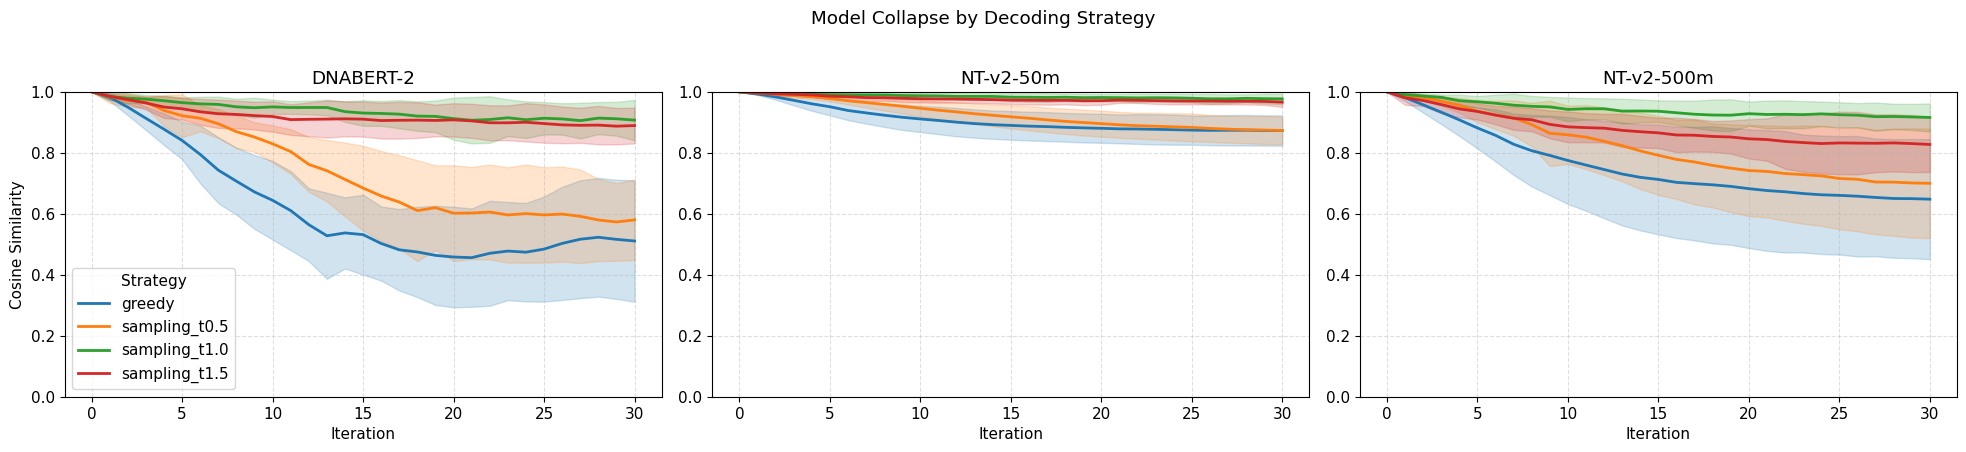

In [16]:
# Strategy mean + std (Side-by-side 배치 - 노트북에서 직접 구성)
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# model_labels = ["DNABERT-2", "NT-v2-500m"]
model_labels = ["DNABERT-2", "NT-v2-50m", "NT-v2-500m"]
ncols = 3
nrows = (len(model_labels) + ncols - 1) // ncols

fig, axes = plt.subplots(
    nrows, ncols, figsize=(6.6 * ncols, 4.4 * nrows), squeeze=False
)

for idx, model_label in enumerate(model_labels):
    row_idx, col_idx = divmod(idx, ncols)
    ax = axes[row_idx, col_idx]
    embeddings_dict = all_embeddings.get(model_label, {})
    
    # 데이터 준비
    from visualization import build_similarity_records
    df = build_similarity_records(embeddings_dict, strategies=None)
    if df.empty:
        ax.set_title("No data")
        ax.set_axis_off()
        continue
    
    # 그리기
    summary = (
        df.groupby(["Strategy", "Iteration"])["Similarity"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    
    strategy_order = list(summary["Strategy"].unique())
    palette = sns.color_palette("tab10", n_colors=len(strategy_order))
    
    for s_idx, strategy_key in enumerate(strategy_order):
        subset = summary[summary["Strategy"] == strategy_key]
        if subset.empty:
            continue
        color = palette[s_idx]
        ax.plot(
            subset["Iteration"], subset["mean"], label=strategy_key,
            color=color, linewidth=2.0
        )
        ax.fill_between(
            subset["Iteration"],
            subset["mean"] - subset["std"],
            subset["mean"] + subset["std"],
            color=color, alpha=0.2
        )
    
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Cosine Similarity" if col_idx == 0 else "")
    ax.set_ylim(0, 1)
    # ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(model_label)
    ax.grid(True, linestyle="--", alpha=0.4)

    if idx == 0:
        ax.legend(title="Strategy")

# 빈 subplot 비활성화
for idx in range(len(model_labels), nrows * ncols):
    row_idx, col_idx = divmod(idx, ncols)
    axes[row_idx, col_idx].axis("off")

fig.suptitle("Model Collapse by Decoding Strategy", y=1.02)
fig.tight_layout()
plt.show()

## 2. gene에 따른 model collapse


### gene length, exon 개수에 따른 model collapse


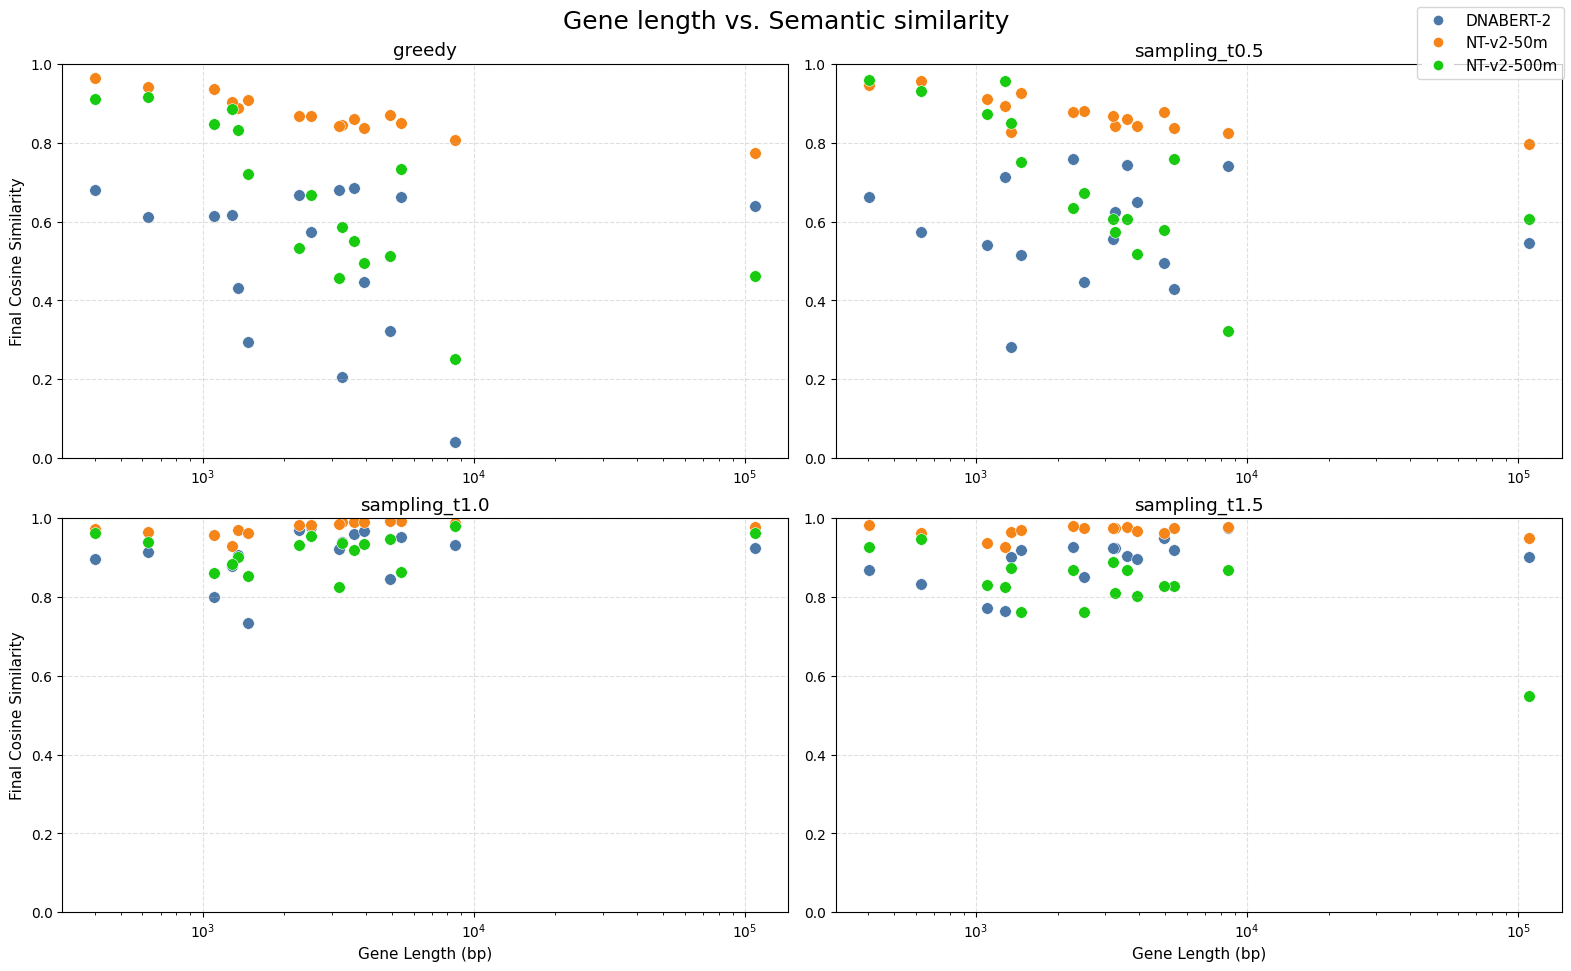

In [19]:
# Same-strategy comparison: two models on one plot (color-coded)
from visualization import _build_final_similarity_property_df
from matplotlib.lines import Line2D

# model_labels = ["DNABERT-2", "NT-v2-500m"]  # 비교할 모델 2개
property_key = "length"
log_x = True

# strategy 목록은 첫 번째 모델 기준으로 가져옴
base_embeddings = all_embeddings.get(model_labels[0], {})
if base_embeddings:
    first_gene = next(iter(base_embeddings.values()))
    strategy_order = list(first_gene.keys())
else:
    strategy_order = []

if not strategy_order:
    print(f"⚠️ No strategies found for {model_labels[0]}.")
else:
    ncols = 2
    nrows = (len(strategy_order) + ncols - 1) // ncols
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(7.8 * ncols, 4.8 * nrows),
        squeeze=False, constrained_layout=True,
    )

    # 모델별 데이터프레임 준비
    model_dfs = {}
    for model_label in model_labels:
        embeddings_dict = all_embeddings.get(model_label, {})
        sequences_dict = all_sequences.get(model_label, {})
        df, property_map = _build_final_similarity_property_df(
            embeddings_dict,
            sequences_dict=sequences_dict,
            gene_metadata=None,
            property_key=property_key,
            strategies=None,
            prefer_strategy=None,
        )
        if not property_map or df.empty:
            print(f"⚠️ No data for {model_label}.")
            continue
        df = df.copy()
        df["Model"] = model_label
        model_dfs[model_label] = df

    if len(model_dfs) == 0:
        print("⚠️ No model data available for plotting.")
    else:
        # 색상 고정
        palette = {model_labels[0]: "#4C78A8", model_labels[1]: "#F58518", model_labels[2]: "#19CB10"}
        for idx, strategy in enumerate(strategy_order):
            row_idx, col_idx = divmod(idx, ncols)
            ax = axes[row_idx][col_idx]

            plotted = False
            for model_label, df in model_dfs.items():
                subset = df[df["Strategy"] == strategy]
                if subset.empty:
                    continue
                sns.scatterplot(
                    data=subset,
                    x="Property",
                    y="FinalSimilarity",
                    ax=ax,
                    s=70,
                    color=palette.get(model_label),
                    edgecolor="white",
                    linewidth=0.4,
                    label=model_label,
                    legend=False,
                )
                plotted = True

            if not plotted:
                ax.set_axis_off()
                continue

            ax.set_title(strategy)
            if col_idx == 0:
                ax.set_ylabel("Final Cosine Similarity")
            else:
                ax.set_ylabel("")
            ax.set_ylim(0, 1)
            if log_x:
                ax.set_xscale("log")
            xlabel = "Gene Length (bp)" if property_key == "length" else "Exon Count"
            if row_idx == nrows - 1:
                ax.set_xlabel(xlabel)
            else:
                ax.set_xlabel("")
            # ax.grid(True, which="both", linestyle=":", linewidth=0.8, alpha=0.6)
            ax.tick_params(axis="both", which="major", labelsize=10)
            ax.grid(True, linestyle="--", alpha=0.4)


        for idx in range(len(strategy_order), nrows * ncols):
            row_idx, col_idx = divmod(idx, ncols)
            axes[row_idx][col_idx].axis("off")

        handles = [
            Line2D([0], [0], marker="o", color="w",
                  markerfacecolor=palette.get(model_label), markersize=8,
                  label=model_label)
            for model_label in model_labels
        ]
        fig.legend(handles=handles, loc="upper right", frameon=True)
        fig.suptitle("Gene length vs. Semantic similarity", fontsize=18)
        plt.show()


In [10]:
from sequence_generation import DEFAULT_GENES

gene_type_map = {gene: meta.get('type') for gene, meta in DEFAULT_GENES.items()}
gene_status_map = {gene: meta.get('status') for gene, meta in DEFAULT_GENES.items()}


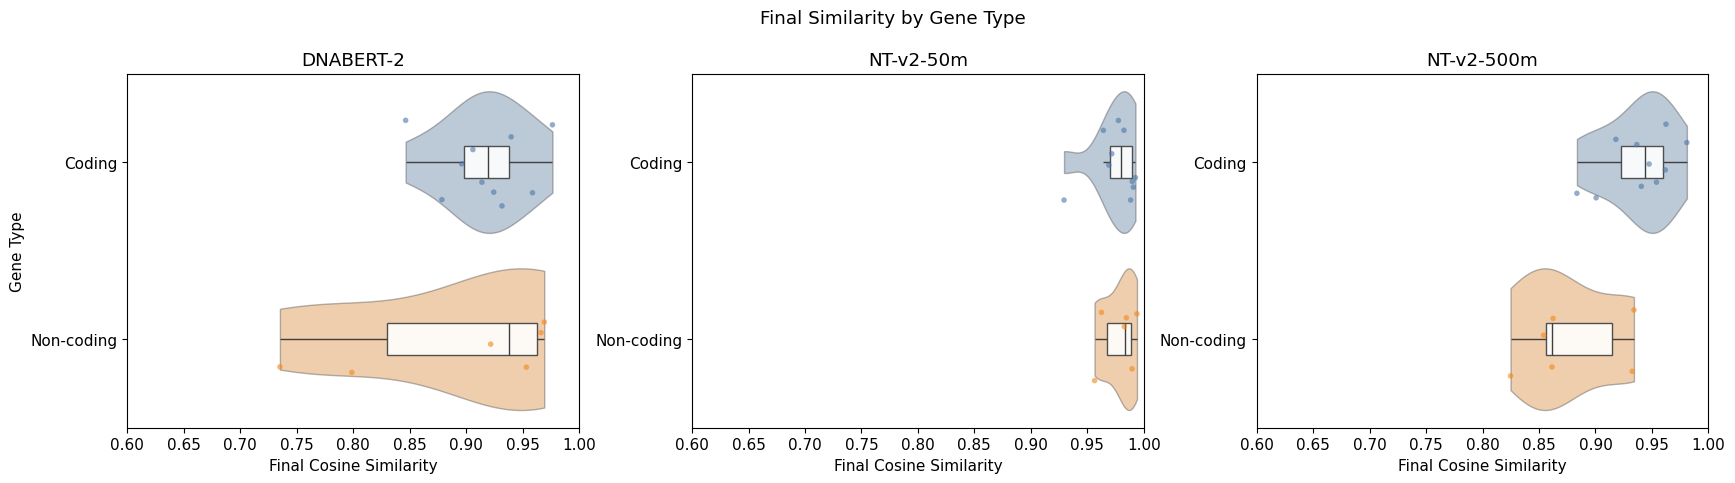

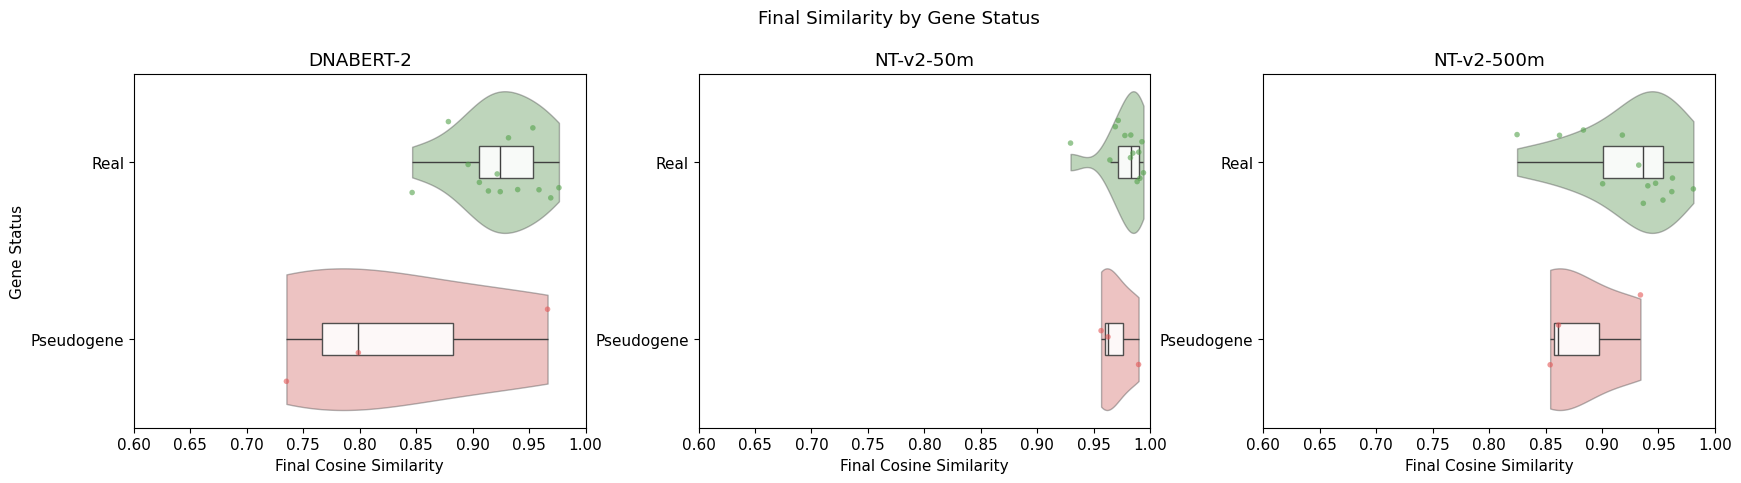

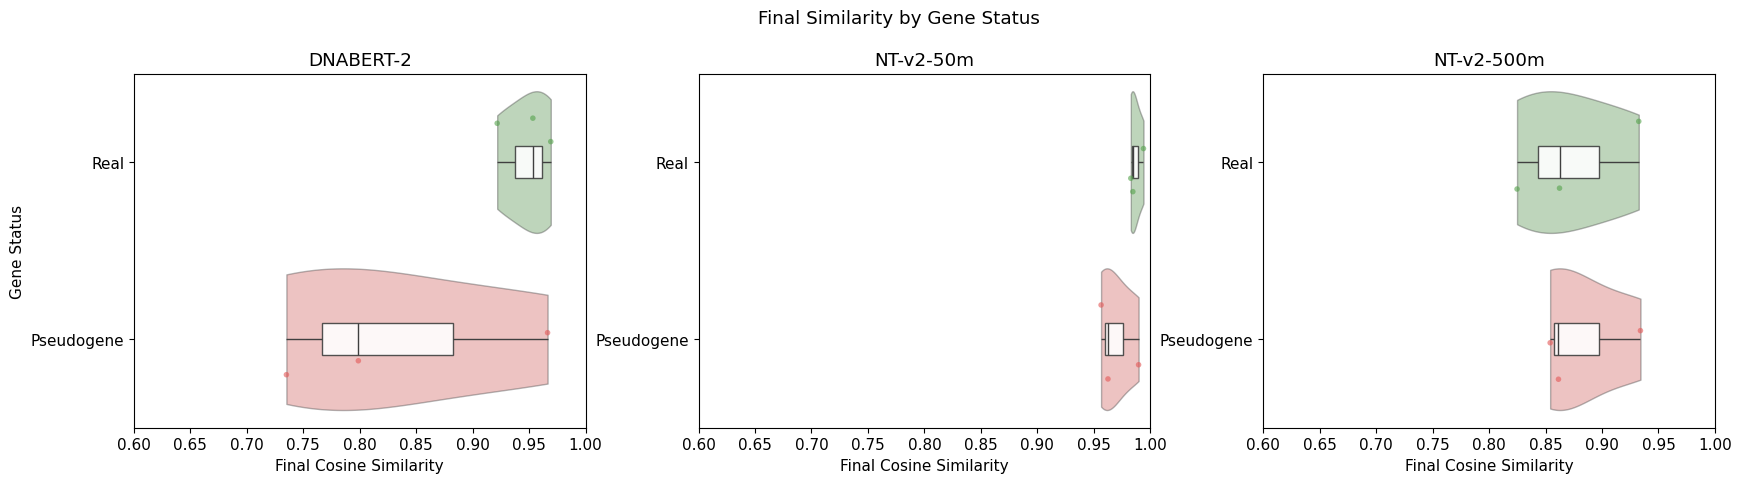

In [20]:
from visualization import _plot_final_similarity_raincloud_on_ax

model_labels = list(all_embeddings.keys())

# ===== 1) Coding vs Non-coding (side-by-side) =====
n_models = len(model_labels)
fig = plt.figure(figsize=(6.8 * n_models, 4.6))
grid = fig.add_gridspec(1, n_models, wspace=0.25)

for idx, model_label in enumerate(model_labels):
    ax = fig.add_subplot(grid[0, idx])
    embeddings_dict = all_embeddings.get(model_label, {})
    palette = {"Coding": "#4C78A8", "Non-coding": "#F58518"}
    _plot_final_similarity_raincloud_on_ax(
        ax,
        embeddings_dict,
        category_map=gene_type_map,
        category_label="Gene Type",
        order=["Coding", "Non-coding"],
        strategies="sampling_t1.0",
        model_label=model_label,
        palette=palette,
        show_ylabel=(idx == 0),
    )
    y_labels = ["Coding", "Non-coding"]
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)
fig.suptitle("Final Similarity by Gene Type", y=1.02)
plt.show()

# ===== 2) Real vs Pseudogene (side-by-side) =====
n_models = len(model_labels)
fig = plt.figure(figsize=(6.8 * n_models, 4.6))
grid = fig.add_gridspec(1, n_models, wspace=0.25)

for idx, model_label in enumerate(model_labels):
    ax = fig.add_subplot(grid[0, idx])
    embeddings_dict = all_embeddings.get(model_label, {})
    palette = {"Real": "#54A24B", "Pseudogene": "#E45756"}
    _plot_final_similarity_raincloud_on_ax(
        ax,
        embeddings_dict,
        category_map=gene_status_map,
        category_label="Gene Status",
        order=["Real", "Pseudogene"],
        strategies="sampling_t1.0",
        model_label=model_label,
        palette=palette,
        show_ylabel=(idx == 0),
        gene_type_map=gene_type_map,
        type_filter=None,
    )
    y_labels = ["Real", "Pseudogene"]
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)
fig.suptitle("Final Similarity by Gene Status", y=1.02)
plt.show()

# ===== 2) Real vs Pseudogene (side-by-side) =====
n_models = len(model_labels)
fig = plt.figure(figsize=(6.8 * n_models, 4.6))
grid = fig.add_gridspec(1, n_models, wspace=0.25)

for idx, model_label in enumerate(model_labels):
    ax = fig.add_subplot(grid[0, idx])
    embeddings_dict = all_embeddings.get(model_label, {})
    palette = {"Real": "#54A24B", "Pseudogene": "#E45756"}
    _plot_final_similarity_raincloud_on_ax(
        ax,
        embeddings_dict,
        category_map=gene_status_map,
        category_label="Gene Status",
        order=["Real", "Pseudogene"],
        strategies="sampling_t1.0",
        model_label=model_label,
        palette=palette,
        show_ylabel=(idx == 0),
        gene_type_map=gene_type_map,
        type_filter="Non-coding",
    )
    y_labels = ["Real", "Pseudogene"]
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)
fig.suptitle("Final Similarity by Gene Status", y=1.02)
plt.show()

## 3. model에 따른 model collapse


### cross validation across models
generator를 model+strategy로 나눠 heatmap을 그립니다.


''

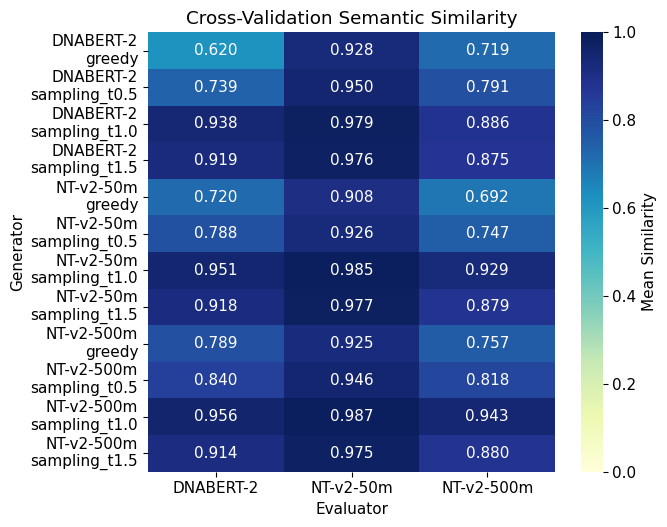

In [21]:
first_model = next(iter(all_embeddings.values()))
first_gene = next(iter(first_model.values()))
strategy_order = list(first_gene.keys())
generator_labels = [
    (model_name, strategy_key)
    for model_name in all_embeddings.keys()
    for strategy_key in strategy_order
]

plot_cross_validation_heatmap(
    cross_embeddings,
    generator_labels=generator_labels,
    evaluator_labels=list(all_embeddings.keys()),
    iteration_range=(0, 50),
)
;

## Another Metrics

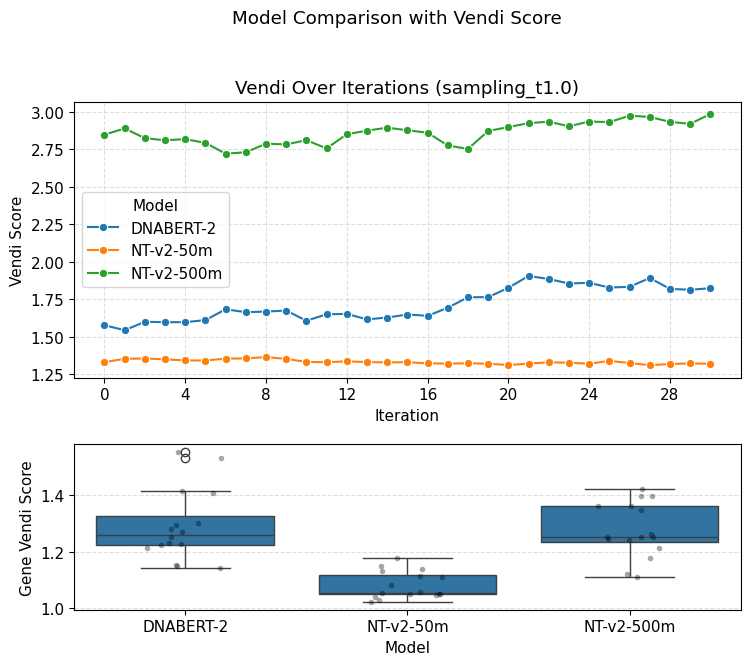

In [13]:
from visualization import plot_vendi_model_comparison

fig = plot_vendi_model_comparison(
    all_embeddings,
    strategy="sampling_t1.0",
)
if fig is not None:
    ax = fig.axes[0] if fig.axes else None
    if ax is not None:
        ax.grid(True, linestyle="--", alpha=0.4)
if fig is not None:
    plt.show()
